## Import library and data

In [1]:
import pandas as pd
import regex as re
import nltk
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('un-general-debates-blueprint.csv.gz')

## Create function to clean data (Credit:T.Santitham Prom-on)

In [3]:
stopwords = set(nltk.corpus.stopwords.words('english'))
stopwords

def tokenize(text):
    return re.findall(r'[\w-]*\p{L}[\w-]*', text)

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

def ngrams(tokens, n=2, sep=' ', stopwords=set()):
    return [sep.join(ngram) for ngram in zip(*[tokens[i:] for i in range(n)])
           if len([t for t in ngram if t in stopwords])==0]

## Fit pipeline to data

In [4]:
df['tokens'] = df['text'].apply(prepare, pipeline=pipeline)

## Separate to 2 part (1970 -> 1990 and 1990 -> the lastest)

In [5]:
first_part = df.query("1970<=year<=1990")
last_part = df.query("1990<=year")

In [6]:
fp_tokens = first_part['tokens'].explode().values
lp_tokens = last_part['tokens'].explode().values

In [7]:
ng_1 = ngrams(fp_tokens,2,stopwords=stopwords)

In [9]:
ng_2 = ngrams(lp_tokens,2,stopwords=stopwords)

## 1.Find the top 10 word bigram from US General Debates of years 1970 – 1990 and compare with those of years 1990 - the latest

In [10]:
counter_ng1 = Counter(ng_1)
counter_ng1.most_common(10)

[('united nations', 43846),
 ('general assembly', 13915),
 ('developing countries', 11991),
 ('international community', 11506),
 ('south africa', 9300),
 ('united states', 7718),
 ('middle east', 7608),
 ('security council', 7500),
 ('peace security', 6755),
 ('human rights', 6569)]

In [23]:
counter_ng2 = Counter(ng_2)
counter_ng2.most_common(10)

[('united nations', 61529),
 ('international community', 16924),
 ('security council', 14040),
 ('general assembly', 13694),
 ('human rights', 13658),
 ('peace security', 8704),
 ('developing countries', 7027),
 ('member states', 6037),
 ('sustainable development', 5281),
 ('climate change', 5159)]

## 2.Create a bigram word cloud of the US General Debates dataset of years 1970 – 1990 and 1990 to the latest (remove stopwords first)

(-0.5, 399.5, 199.5, -0.5)

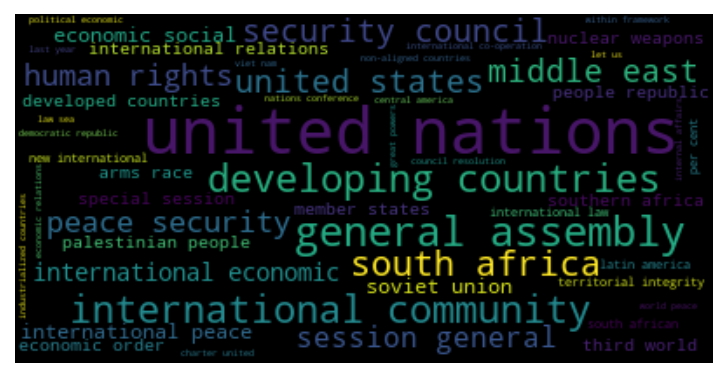

In [12]:
wc = WordCloud(max_words=50, stopwords=stopwords).generate_from_frequencies(counter_ng1)
plt.figure(dpi=150)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

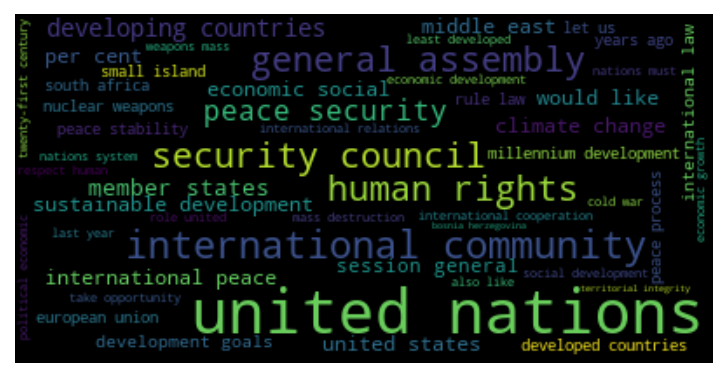

In [13]:
wc = WordCloud(max_words=50, stopwords=stopwords).generate_from_frequencies(counter_ng2)
plt.figure(dpi=150)
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

## Combined tokens and bi gram to new column in dataframe

In [14]:
list_ngram = []
for i in range(len(df)):
    list_ngram.append(ngrams(df.iloc[i,7],2,stopwords=stopwords))

In [15]:
df['ngram'] = list_ngram

In [16]:
df['tokens+ngram'] = df['tokens'] + df['ngram']

## Create function to count keywords (Credit:T.Santitham Prom-on)

In [17]:
def count_keywords(tokens, keywords):
    tokens = [t for t in tokens if t in keywords]
    counter = Counter(tokens)
    return [counter.get(k, 0) for k in keywords]

In [18]:
def count_keywords_by(df, by, keywords, column='tokens+ngram'):
    freq_matrix = df[column].apply(count_keywords, keywords=keywords)
    freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
    freq_df[by] = df[by]
    
    return freq_df.groupby(by).sum().sort_values(by)

## 3. Create a trend graph showing the bigram and word trend of “climate change”, “global warming”, “wars” and 3 others of your choices (in this case i choose “general assembly”,“united nations”,“economic social”)

In [20]:
keywords = ['global warming','climate change','wars','general assembly','united nations','economic social']

In [21]:
fq_words = count_keywords_by(df, by='year', keywords=keywords)

<AxesSubplot:xlabel='year'>

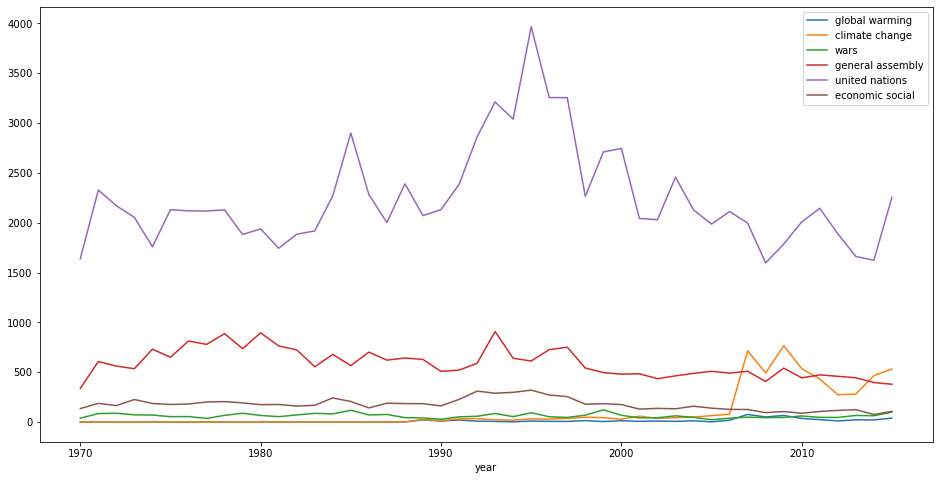

In [22]:
fq_words.plot(kind='line', figsize=(16,8))